In [ ]:
import os
import time
import re
from datetime import datetime, timedelta
#These paths match the paths created by the code I contributed to https://github.com/SaltieRL/ReplayModels
#For now we throw everything we generate in this notebook in the datasets path, because I'm lazy
bpath = 'ReplayDataProcessing\\RANKED_DUELS\\Datasets\\1000-1200\\'
dpath = bpath + 'cleaner.h5'
vpath = bpath + 'cleaner-test_set.h5'
bins_path = bpath + 'datacols1bins\\'
h5path = bpath + 'h5\\'
model_path = bpath + 'models\\'
code_path = bpath + 'c_code\\'
num_players = 1
cols_p = 18
cols_g = 17
colsg2 = 12
#dpath = 'ReplayDataProcessing\RANKED_DUELS\Datasets'
assert os.path.isfile(dpath)


In [3]:
import numpy as np
import pandas as pd
import h5py
import matplotlib
import matplotlib.pyplot as plt
#LightGBM
import lightgbm as lgb
#Sklearn
from sklearn.preprocessing import MinMaxScaler as mms
from sklearn.preprocessing import RobustScaler as rs
from sklearn.preprocessing import PowerTransformer as pt
from sklearn.preprocessing import LabelEncoder, minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
#List of columns we are dropping for training. These features were low power and hard to handle in bakkesmod
droplist = ['z_0_dodge_active', 'z_0_jump_active', 'z_0_double_jump_active','o_0_dodge_active','o_0_jump_active', 'o_0_double_jump_active','ball_rot_x', 'ball_rot_y', 'ball_rot_z', 'ball_ang_vel_x', 'ball_ang_vel_y', 'ball_ang_vel_z', 'game_seconds_remaining', 'score_zero','score_one', 'secs_to_goal']

In [4]:
#Ranges
bakkes_ranges_0 = [(0,1), (0,2), (1,3), (2,5), (3,7), (5,9), (7,12), (9, 15)] #Remembering the old ranges
ranges = [(0,3),(2,5),(3,7),(4,8),(6,10),(7,12),(9,14),(11,16)] #The current ranges

In [5]:
def mirror_df(input_df, num_players):
    #This function takes a dataframe of game data and flips it so that it is a mirror copy where the blue player is orange and the orange player is blue (ball also mirrored)
    #For now, 1v1
    try:
        assert len(input_df.columns) == 37
    except:
        print(input_df.columns)
        raise Exception
    #Prepare flipping teams
    cols = input_df.columns.tolist()
    flipped_cols = cols[15:30] + cols[0:15] + cols[30:]
    df = input_df.copy()[flipped_cols]
    df.columns = cols
    #Get columns for flipping
    players = ['z_0_', 'o_0_','z_1_', 'o_1_','z_2_', 'o_2_',]
    entities = (players[:num_players*2])
    entities.append('ball_')
    flipping = ['pos_x', 'pos_y', 'vel_x', 'vel_y', 'ang_vel_x', 'ang_vel_y' ]
    for e in entities:
        if e is 'ball_':
            for col in flipping[:4]:
                df.loc[:, e + col] *= -1
        else:
            for col in flipping:
                df.loc[:, e + col] *= -1
            #Also 'encode' by subtracting 10 so the values don't get picked up by the second query
            df.loc[df[e + 'rot_y']> 0, e + 'rot_y'] -= (np.pi + 10)
            df.loc[(df[e + 'rot_y']< 0) & (df[e + 'rot_y']> -np.pi), e + 'rot_y'] += np.pi
            #'Decode' the first change
            df.loc[df[e + 'rot_y']< -np.pi, e + 'rot_y'] += 10
    # (1 -> -1) (0 -> 0)
    df['next_goal_one'] *= -1
    # (-1 -> 0) (0 -> 1)
    df['next_goal_one'] += 1
    return df

In [6]:
def df_to_int(input_df):
    #Make a game dataframe smaller by changing the types
    df = input_df.copy(deep = True)
    sub_dict = {"pos": [1, np.int16], "rot": [1000, np.int16], "vel": [1, np.int16], "boost": [1, np.uint8], "active": [1, np.int8], "next": [1, np.int8], "is": [1, np.int8], 
                "sec": [1, np.int16], "score":[1, np.int8]}
    for sub, ops in sub_dict.items():
        cols = [col for col in df.columns if sub in col]
        for col in cols:
            df[col] = (df[col] * ops[0]).astype(ops[1])
    return df

In [7]:
#Not working, reference function for the new functions
# def get_balanced_df(data_path, secs, team_int):
#     assert os.path.isfile(data_path)
#     assert(team_int==0 or team_int==1)
#     num_frames = h5py.File(data_path)['data']['table'].shape[0]
#     team = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = team_int')
#     team.drop(['game_seconds_remaining', 'secs_to_goal', 'score_zero','score_one'], axis = 1, inplace = True)
#     team.reset_index(drop=True, inplace = True)
#     assert (team['next_goal_one'] == team_int).all()
#     team['next_goal_one'] = 1
#     target = len(team)
#     print(target * 2)
    
#     index = 0
#     pulls = []
#     end = index + target
#     while target > 0:
#         df = pd.read_hdf(data_path, start = index, stop = end)
#         df = df.drop(['game_seconds_remaining', 'score_zero','score_one'], axis = 1)        
#         df = df[df['secs_to_goal'] > secs[1]]
#         df = df.drop(['secs_to_goal'], axis = 1)
        
#         index += target
#         target -= len(df)
#         pulls.append(df)
#         if index + target > num_frames:
#             end = num_frames
#         else:
#             end = index + target
    
#     #Trying to minimize RAM spikes    
#     no_goal = pd.concat(pulls)
#     del pulls
#     #Rename cols
#     no_goal['next_goal_one'] = 0

#     combined = pd.concat([team, no_goal])
#     return combined.drop(['next_goal_one'], axis = 1), combined['next_goal_one']

In [8]:
def get_balanced_mirrored_df(data_path, secs):
    #Where x is the total number of frames in the data_path s.t. secs_to_goal is in the range "secs"
    #The returned dataframe consists of
    #A: x frames in range and orange goal (half of which are mirrored blue goal frames) label = 1
    #B : x/2 frames in range and blue goal (sampled from A) label = 0
    #C: x frames out of range label = 0
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]
    
    odf = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 1')
    odf = odf.drop(droplist, axis = 1)
    odf = df_to_int(odf)
    odf.reset_index(drop=True, inplace = True)
    assert (odf['next_goal_one'] == 1).all()
       
    zdf = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 0')
    zdf = zdf.drop(droplist, axis = 1)
    zdf = df_to_int(zdf)
    zdf.reset_index(drop=True, inplace = True)
    assert (zdf['next_goal_one'] == 0).all()
    
    if len(zdf) < len(odf):
        odf = odf.truncate(after = len(zdf)-1)
    elif len(zdf) > len(odf):
        zdf = zdf.truncate(after = len(odf)-1)
    mdf = mirror_df(zdf, 1)
    assert (mdf['next_goal_one'] == 1).all()
    #They are mirrored so we can combine their length (slow to combine now, better to wait)
    if len(zdf) != len(odf):
        print(len(zdf))
        print(len(odf))
        
    target = int(len(odf) * 1.5 + len(zdf) * 1.5)
    print(f'total rows: {target * 2.5}')
    index = 0
    step = 10000
    pulls = []
    end = min(step, target)
    while (end - index) > 0:
        df = pd.read_hdf(data_path, start = index, stop = end)
        index = end
        #Either step, or stop at target, or stop at end of file
        end = min(index + step, target, num_frames)
                
        df = df.drop(droplist[:-1], axis = 1)
        df = df[df['secs_to_goal'] >= secs[1]]
        df = df.drop(['secs_to_goal'], axis = 1)
        df['next_goal_one'] = 0
        df = df_to_int(df)
        pulls.append(df)
    
    #Trying to minimize RAM spikes
    no_goal = pd.concat(pulls)
    del pulls
    #combined labels: [1,1,0,0,0]
    combined = pd.concat([odf, mdf, no_goal, zdf.sample(frac = 0.5), mirror_df(odf, 1).sample(frac = 0.5)])
    del odf, mdf, no_goal, zdf
    return combined.drop(['next_goal_one'], axis = 1), combined['next_goal_one'], len(combined)

In [9]:
def get_df(data_path, secs, size):
    #Gets the regular distribution with no changes "Real" data unaltered
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]

    df_iter = pd.read_hdf(data_path, iterator = True, chunksize = size)
    for single_chunk in df_iter:
        full_df = single_chunk
        break
    full_df = full_df.drop(droplist[:-1], axis =1)
    df = full_df.loc[(full_df['secs_to_goal'] >= secs[0]) & (full_df['secs_to_goal'] < secs[1])]
    non_df = full_df.loc[full_df['secs_to_goal'] >= secs[1]]
    df = df.drop(['secs_to_goal'], axis = 1)
    non_df = non_df.drop(['secs_to_goal'], axis = 1)
    del full_df
    non_df['next_goal_one'] = 0
    combined = df.append(non_df, ignore_index = True)
    del df, non_df
    combined = df_to_int(combined)
    print(f'total rows: {len(combined)}')
    return combined.drop(['next_goal_one'], axis = 1), combined['next_goal_one']

In [10]:
def write_balanced_mirrored_h5(data_path, name, secs, max_score_diff, chunk, val = False):
    #Where x = chunk
    #The returned dataframe (written h5) consists of
    #A: x frames in range and orange goal (~half of which are mirrored blue goal frames) label = 1
    #B : x/2 frames in range and blue goal (sampled from A) label = 0
    #C: x frames out of range label = 0
    chunk //= 2
    chunk_s = 50000
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]
    if val:
        v = '_val'
    else:
        v = ''
    h5_path = f"{h5path}{name}_{str(secs[0])}-{str(secs[1])}{v}.h5"
    lens = []
    for i in range(2):
        df_iter = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = i', iterator = True, chunksize = chunk_s)
        pulls = []
        count = 0
        for df in df_iter:
            df = df.loc[abs(df['score_one'] - df['score_zero']) <= max_score_diff]
            df = df.drop(droplist, axis = 1)
            df = df_to_int(df)
            pulls.append(df)
            count += len(df)
            if count >= chunk:
                break
        df = pd.concat(pulls)
        df.reset_index(drop=True, inplace = True)
        lens.append(len(df))
        mdf = mirror_df(df,1)
        mdf = df_to_int(mdf)
        if(i == 0):
            assert (df['next_goal_one'] == 0).all()
            assert (mdf['next_goal_one'] == 1).all()
            df.sample(frac = 0.5).to_hdf(h5_path,'data', mode='w', format='table')
            del df
            mdf.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
            del mdf
        if(i == 1):
            assert (df['next_goal_one'] == 1).all()
            assert (mdf['next_goal_one'] == 0).all()
            df.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
            del df
            mdf.sample(frac = 0.5).to_hdf(h5_path,'data', mode='r+', format='table', append=True)
            
            del mdf
    #They are mirrored so we can combine their length (slow to combine now, better to wait)
    print(f'blue   ratio: {lens[0]/(lens[0]+lens[1])}')
    print(f'orange ratio: {lens[1]/(lens[0]+lens[1])}')
    
    target = int(lens[0] * 1.5 + lens[1] * 1.5)
    print(f'total rows: {target * 2}')
    
    index = 0
    step = 50000
    pulls = []
    end = min(step, target)
    while (end - index) > 0:
        try:
            df = pd.read_hdf(data_path, start = index, stop = end)
        except:
            print(index)
            print(end)
            print(min(index + step, target, num_frames))
            raise Exception
        index = end
        #Either step, or stop at target, or stop at end of file
        end = min(index + step, target, num_frames)
                
        df = df.drop(droplist[:-1], axis = 1)
        df = df[df['secs_to_goal'] >= secs[1]]
        df = df.drop(['secs_to_goal'], axis = 1)
        df['next_goal_one'] = 0.0
        df = df_to_int(df)
        pulls.append(df)
    #Trying to minimize RAM spikes
    no_goal = pd.concat(pulls)
    print(f'blue: {lens[0] * 1.5} orange: {lens[1] * 1.5} no_goal: {len(no_goal)}')
    del pulls
    no_goal.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
    return h5_path

## Create Range Datasets

### Create mirrored range h5 files and datasets

In [136]:
for i in ranges:
    print(i)
    hpath = write_balanced_mirrored_h5(dpath, "new_bakkes", i, 4, 100000000)
    #With the LGBMClassifier, no longer need to save datasets.
    #hpath = f'ReplayDataProcessing\\RANKED_DUELS\\Datasets\\1000-1200\\h5\\mirror_data_{i[0]}-{i[1]}.h5'
#     x = pd.read_hdf(hpath)
#     y = x['next_goal_one']
#     x = x.drop(['next_goal_one'], axis = 1)
#     data_path = f"{bins_path}new_bakkes{str(i[0])}-{str(i[1])}.bin"
#     dataset = lgb.Dataset(x, label= y)   
#     dataset.save_binary(data_path)
#     del x, y, dataset

(0, 3)
blue   ratio: 0.5004997872435359
orange ratio: 0.49950021275646406
total rows: 33080076
blue: 5518857 orange: 5507835 no_goal: 14928487
(2, 5)
blue   ratio: 0.5009387797949291
orange ratio: 0.49906122020507093
total rows: 37237166
blue: 6217847 orange: 6194542 no_goal: 15434109
(3, 7)
blue   ratio: 0.5012353978992659
orange ratio: 0.4987646021007342
total rows: 48407076
blue: 8087780 orange: 8047912 no_goal: 18410020
(4, 8)
blue   ratio: 0.5011635071431422
orange ratio: 0.4988364928568578
total rows: 47063742
blue: 7862210 orange: 7825704 no_goal: 17153596
(6, 10)
blue   ratio: 0.5013887178568236
orange ratio: 0.4986112821431764
total rows: 42657692
blue: 7129362 orange: 7089869 no_goal: 14258268
(7, 12)
blue   ratio: 0.5008805906338338
orange ratio: 0.49911940936616617
total rows: 50775012
blue: 8477406 orange: 8447598 no_goal: 15538629
(9, 14)
blue   ratio: 0.5000256938777976
orange ratio: 0.4999743061222024
total rows: 47170770
blue: 7862199 orange: 7861391 no_goal: 13219253


# MAIN SINGLE

In [ ]:
#Code is redacted for being old and unused

# Bakkes Models

(0, 3)
total rows: 10761052.5
total rows: 16362286
0.21
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.302928	valid_1's binary_logloss: 0.221116
[400]	valid_0's binary_logloss: 0.291845	valid_1's binary_logloss: 0.216112
Early stopping, best iteration is:
[530]	valid_0's binary_logloss: 0.287973	valid_1's binary_logloss: 0.215032
              precision    recall  f1-score   support

           0       0.92      0.91      0.91   5313900
           1       0.83      0.85      0.84   2869614

    accuracy                           0.89   8183514
   macro avg       0.87      0.88      0.88   8183514
weighted avg       0.89      0.89      0.89   8183514

              precision    recall  f1-score   support

           0       0.99      0.92      0.95   7782300
           1       0.34      0.85      0.49    398843

    accuracy                           0.91   8181143
   macro avg       0.67      0.88      0.72   8181143
weighted avg       0

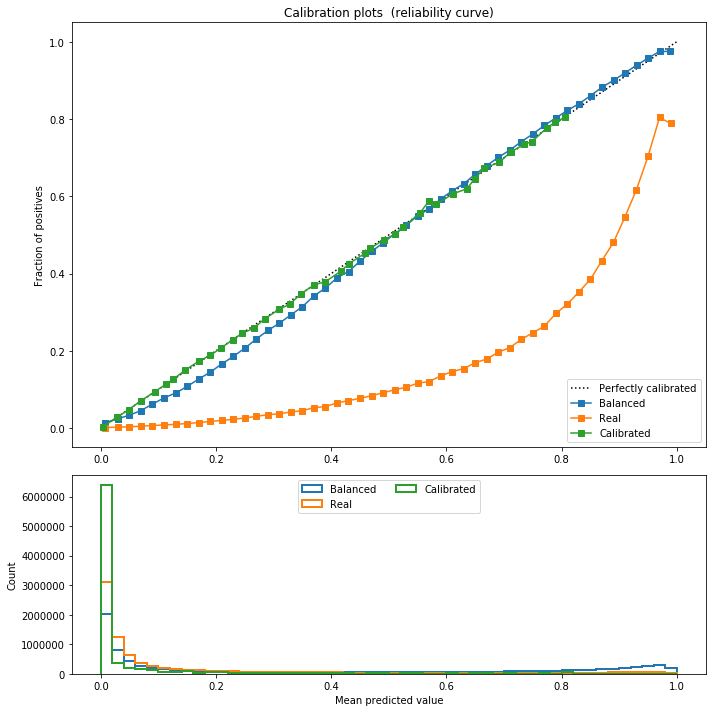

[[0.90656486 0.09343514]
 [0.14986754 0.85013246]]
[[0.91697069 0.08302931]
 [0.14813348 0.85186652]]
[[0.99043149 0.00956851]
 [0.59409843 0.40590157]]
(2, 5)
total rows: 12066975.0
total rows: 16527539
0.18
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.426306	valid_1's binary_logloss: 0.357634
[400]	valid_0's binary_logloss: 0.412866	valid_1's binary_logloss: 0.348041
[600]	valid_0's binary_logloss: 0.405147	valid_1's binary_logloss: 0.343101
[800]	valid_0's binary_logloss: 0.400343	valid_1's binary_logloss: 0.339633
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.400343	valid_1's binary_logloss: 0.339633
              precision    recall  f1-score   support

           0       0.83      0.88      0.86   5600776
           1       0.77      0.70      0.73   3217860

    accuracy                           0.81   8818636
   macro avg       0.80      0.79      0.79   8818636
weighted avg       0.81      

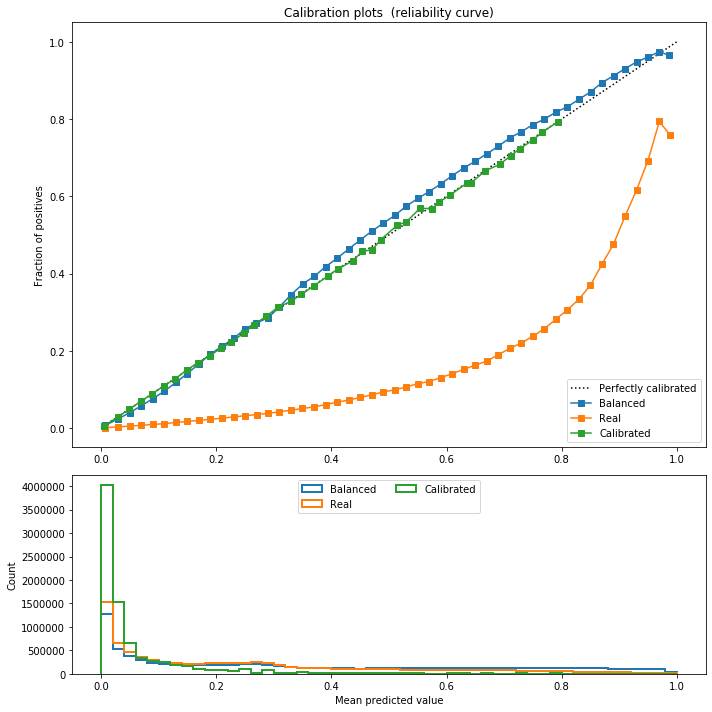

[[0.88059601 0.11940399]
 [0.3039837  0.6960163 ]]
[[0.85503978 0.14496022]
 [0.2963421  0.7036579 ]]
[[0.99510053 0.00489947]
 [0.85261808 0.14738192]]
(3, 7)
total rows: 15659122.5
total rows: 19844012
0.16
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.537596	valid_1's binary_logloss: 0.438506
[400]	valid_0's binary_logloss: 0.528911	valid_1's binary_logloss: 0.432937
[600]	valid_0's binary_logloss: 0.52373	valid_1's binary_logloss: 0.4294
[800]	valid_0's binary_logloss: 0.519419	valid_1's binary_logloss: 0.427487
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.519419	valid_1's binary_logloss: 0.427487
              precision    recall  f1-score   support

           0       0.75      0.87      0.80   6834511
           1       0.70      0.52      0.59   4175766

    accuracy                           0.73  11010277
   macro avg       0.72      0.69      0.70  11010277
weighted avg       0.73      0.7

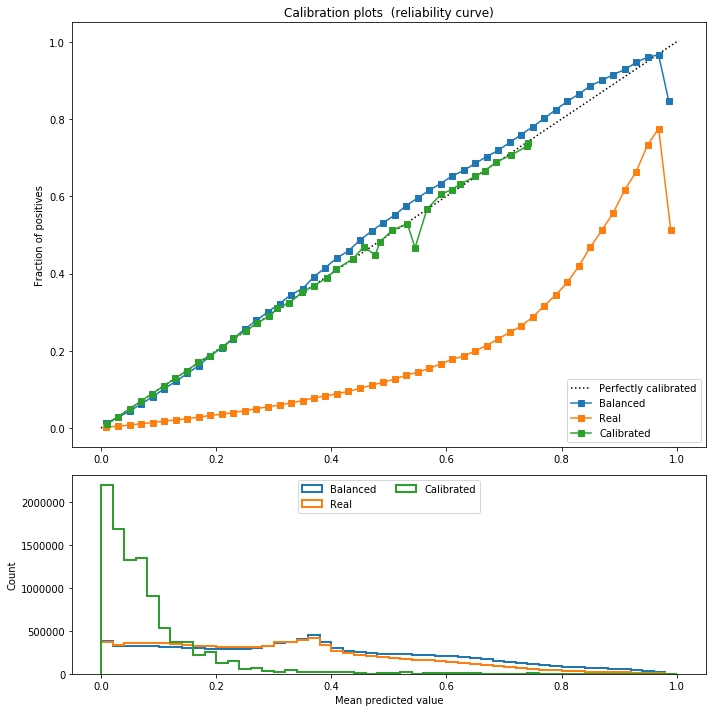

[[0.86699297 0.13300703]
 [0.48481093 0.51518907]]
[[0.84065112 0.15934888]
 [0.48305748 0.51694252]]
[[0.99637138 0.00362862]
 [0.93512061 0.06487939]]
(4, 8)
total rows: 15226162.5
total rows: 18186843
0.13
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.58279	valid_1's binary_logloss: 0.467563
[400]	valid_0's binary_logloss: 0.576927	valid_1's binary_logloss: 0.464067
[600]	valid_0's binary_logloss: 0.573079	valid_1's binary_logloss: 0.461865
[800]	valid_0's binary_logloss: 0.571086	valid_1's binary_logloss: 0.460203
Did not meet early stopping. Best iteration is:
[792]	valid_0's binary_logloss: 0.571073	valid_1's binary_logloss: 0.460157
              precision    recall  f1-score   support

           0       0.70      0.87      0.78   6450128
           1       0.67      0.41      0.50   4060310

    accuracy                           0.69  10510438
   macro avg       0.68      0.64      0.64  10510438
weighted avg       0.69      0

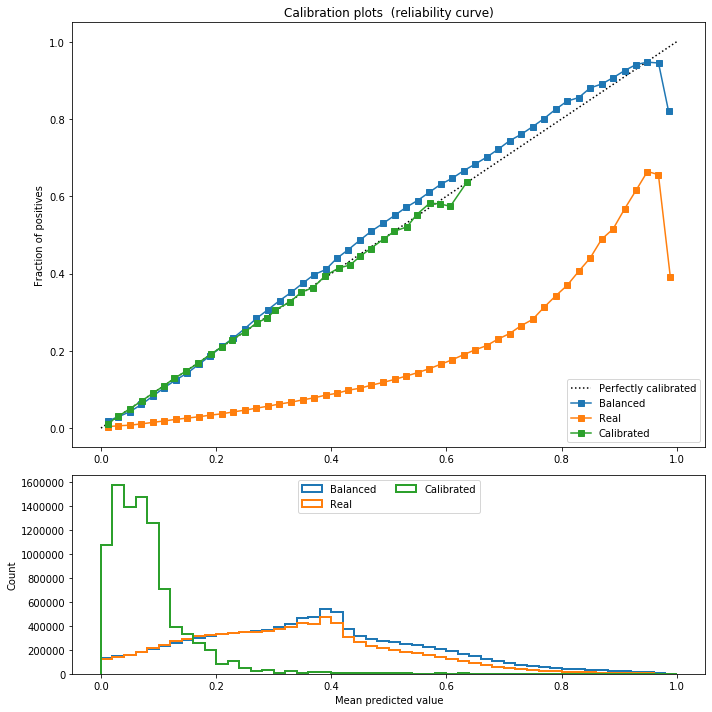

[[0.8720244  0.1279756 ]
 [0.59368226 0.40631774]]
[[0.84832025 0.15167975]
 [0.59120161 0.40879839]]
[[0.99870381 0.00129619]
 [0.98027805 0.01972195]]
(6, 10)
total rows: 13788510.0
total rows: 14522847
0.1
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.633552	valid_1's binary_logloss: 0.495588
[400]	valid_0's binary_logloss: 0.6318	valid_1's binary_logloss: 0.494338
[600]	valid_0's binary_logloss: 0.631022	valid_1's binary_logloss: 0.493502
[800]	valid_0's binary_logloss: 0.630484	valid_1's binary_logloss: 0.492969
Did not meet early stopping. Best iteration is:
[800]	valid_0's binary_logloss: 0.630484	valid_1's binary_logloss: 0.492969
              precision    recall  f1-score   support

           0       0.65      0.89      0.75   5503828
           1       0.62      0.27      0.38   3676936

    accuracy                           0.64   9180764
   macro avg       0.63      0.58      0.56   9180764
weighted avg       0.63      0.

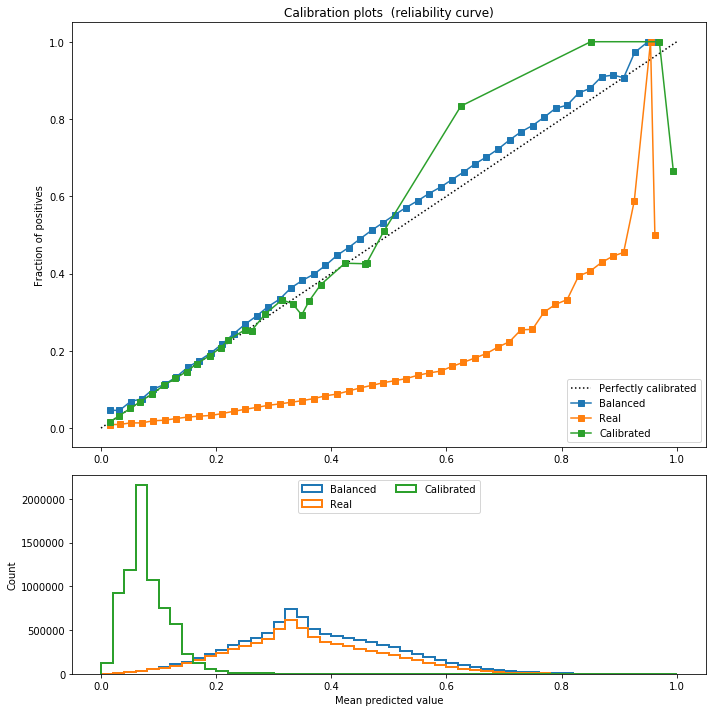

[[0.88585217 0.11414783]
 [0.7257967  0.2742033 ]]
[[0.86710012 0.13289988]
 [0.7308568  0.2691432 ]]
[[9.99999701e-01 2.99030409e-07]
 [9.99984297e-01 1.57029422e-05]]
(7, 12)
total rows: 16436122.5
total rows: 16022624
0.09
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.657072	valid_1's binary_logloss: 0.51535
[400]	valid_0's binary_logloss: 0.656133	valid_1's binary_logloss: 0.514442
[600]	valid_0's binary_logloss: 0.655653	valid_1's binary_logloss: 0.514119
[800]	valid_0's binary_logloss: 0.655419	valid_1's binary_logloss: 0.51374
Did not meet early stopping. Best iteration is:
[799]	valid_0's binary_logloss: 0.655417	valid_1's binary_logloss: 0.513743
              precision    recall  f1-score   support

           0       0.61      0.91      0.73   6187670
           1       0.60      0.18      0.28   4382966

    accuracy                           0.61  10570636
   macro avg       0.61      0.55      0.51  10570636
weighted avg  

C:\Users\isaac\Anaconda3\envs\rl\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95   7226398
           1       0.00      0.00      0.00    784914

    accuracy                           0.90   8011312
   macro avg       0.45      0.50      0.47   8011312
weighted avg       0.81      0.90      0.86   8011312



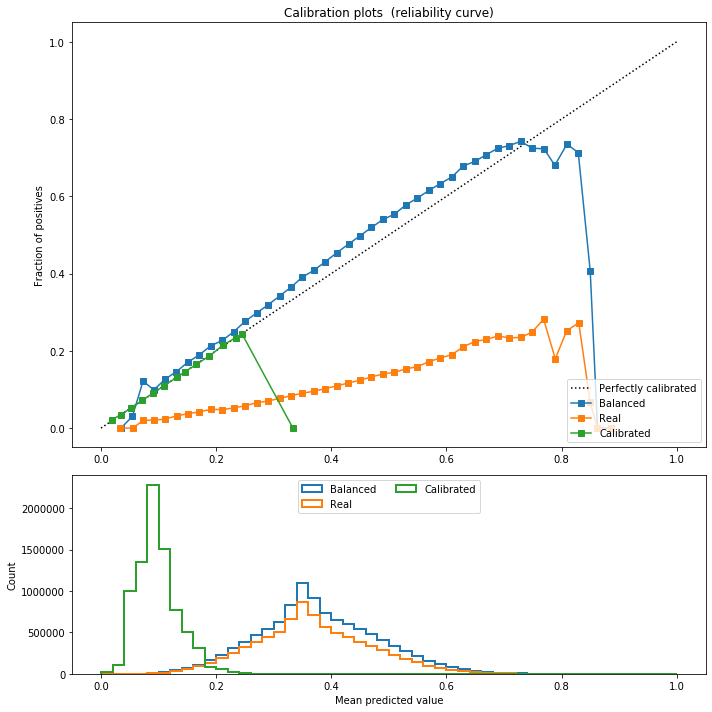

[[0.91434062 0.08565938]
 [0.81780831 0.18219169]]
[[0.90240352 0.09759648]
 [0.8226965  0.1773035 ]]
[[1. 0.]
 [1. 0.]]
(9, 14)
total rows: 15254760.0
total rows: 13192592
0.07
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's binary_logloss: 0.67522	valid_1's binary_logloss: 0.525016
[400]	valid_0's binary_logloss: 0.674814	valid_1's binary_logloss: 0.524401
[600]	valid_0's binary_logloss: 0.67461	valid_1's binary_logloss: 0.52399
[800]	valid_0's binary_logloss: 0.674488	valid_1's binary_logloss: 0.523739
Did not meet early stopping. Best iteration is:
[791]	valid_0's binary_logloss: 0.674482	valid_1's binary_logloss: 0.523783
              precision    recall  f1-score   support

           0       0.58      0.96      0.72   5424924
           1       0.59      0.08      0.14   4067936

    accuracy                           0.58   9492860
   macro avg       0.59      0.52      0.43   9492860
weighted avg       0.58      0.58      0.48   9492860

        

C:\Users\isaac\Anaconda3\envs\rl\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95   5942101
           1       0.00      0.00      0.00    654195

    accuracy                           0.90   6596296
   macro avg       0.45      0.50      0.47   6596296
weighted avg       0.81      0.90      0.85   6596296



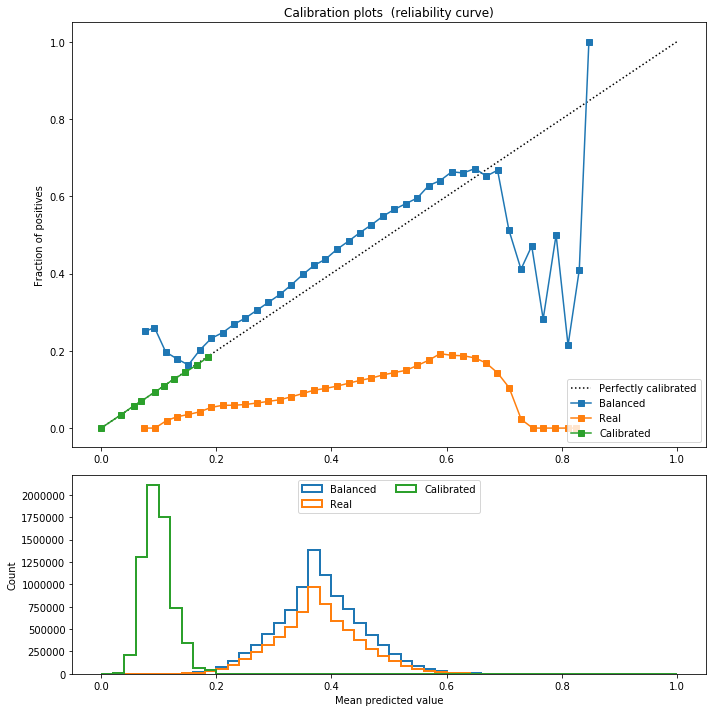

[[0.95682483 0.04317517]
 [0.91768086 0.08231914]]
[[0.95114438 0.04885562]
 [0.91887281 0.08112719]]
[[1. 0.]
 [1. 0.]]
(11, 16)
total rows: 13992600.0
total rows: 10738364
0.002
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.686116	valid_1's binary_logloss: 0.588712
              precision    recall  f1-score   support

           0       0.56      1.00      0.72   4710947
           1       0.53      0.00      0.00   3731360

    accuracy                           0.56   8442307
   macro avg       0.54      0.50      0.36   8442307
weighted avg       0.55      0.56      0.40   8442307

              precision    recall  f1-score   support

           0       0.90      1.00      0.95   4836282
           1       0.14      0.00      0.00    532900

    accuracy                           0.90   5369182
   macro avg       0.52      0.50      0.47   5369182
weighted avg       0.83      0.90      0.85   53

C:\Users\isaac\Anaconda3\envs\rl\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95   4836282
           1       0.00      0.00      0.00    532900

    accuracy                           0.90   5369182
   macro avg       0.45      0.50      0.47   5369182
weighted avg       0.81      0.90      0.85   5369182



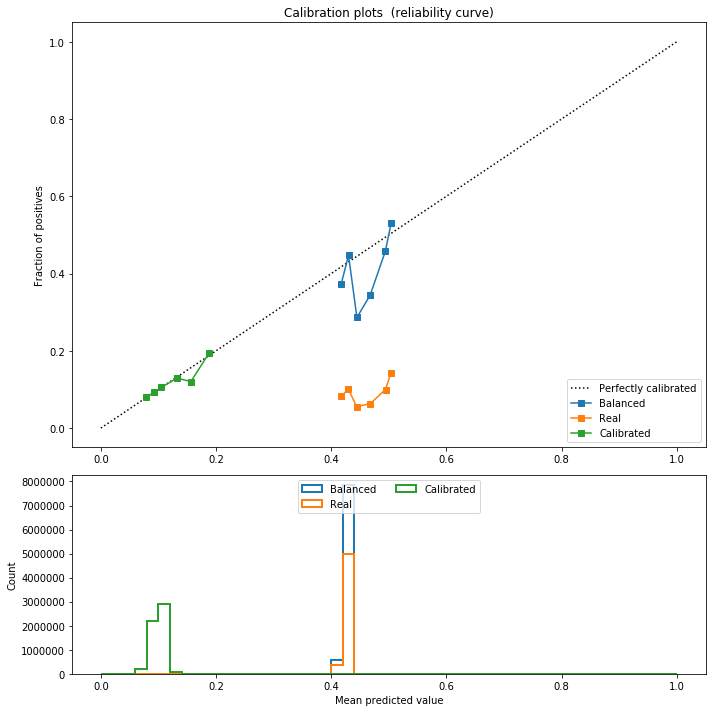

[[9.99927615e-01 7.23845970e-05]
 [9.99896820e-01 1.03179538e-04]]
[[9.99932593e-01 6.74071529e-05]
 [9.99898668e-01 1.01332333e-04]]
[[1. 0.]
 [1. 0.]]


In [40]:
import m2cgen as m2c
import sys
sys.setrecursionlimit(10000)
#Tweaking these to hopefully hit just under n_estimators for each range.
learning_rates = [.21, .2, .18, .16, .14, .11, .07, .002]
save = True #Whether to save over c code
calibrate = False #Whether to save code with calibration
#Storing outputs
codes = []
clfs = []
cals = []
#for tup in range(len(ranges)):
for tup in range(len(ranges)):
    i = ranges[tup]
    print(i)
    #Currently not writing models anywhere
    #mpath = f"{model_path}bakkes_models_{str(i[0])}-{str(i[1])}.boost"
    #Use the path we wrote to
    data_path = f"{h5path}new_bakkes_{str(i[0])}-{str(i[1])}.h5"
    #goss performs very similarly to gbdt
    #No improvement is seen with sampling rate under 1 for columns.
    #Not sure what num_leaves is best yet
    clf = lgb.LGBMClassifier(boosting_type = 'gbdt', num_leaves=31, max_depth=-1, learning_rate=learning_rates[tup], n_estimators=800, subsample_for_bin=20000, objective='binary', is_unbalance = True,
                             min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0,
                             random_state=None, n_jobs=-1, silent=False, importance_type='gain')
    #Get datasets
    train = pd.read_hdf(data_path)
    y = train['next_goal_one']
    X = train.drop(['next_goal_one'], axis = 1)
    del train
    #Get validation
    val_x, val_y, size = get_balanced_mirrored_df(vpath, i)
    split_x, split_y = get_df(vpath, i, size*2)
    cal_x, real_x, cal_y, real_y = train_test_split(split_x, split_y, test_size=0.5, shuffle = True)
    del split_x, split_y
    #Train both
    print(learning_rates[tup])
    clf.fit(X, y, eval_set= [(val_x, val_y), (real_x, real_y)], verbose = 200, early_stopping_rounds = 50)
    clfs.append(clf)
    #Predict and report both
    pred = clf.predict_proba(val_x)[:, 1]
    real_pred = clf.predict_proba(real_x)[:, 1]
    clf_cv = CalibratedClassifierCV(clf, method = 'isotonic', cv = 'prefit')
    clf_cv.fit(cal_x,cal_y)
    cals.append(clf_cv)
    calibrated_pred = clf_cv.predict_proba(real_x)[:,1]

    print(classification_report(val_y, pred.round()))
    print(classification_report(real_y, real_pred.round()))
    print(classification_report(real_y, calibrated_pred.round()))
    #Plot calibration
    plot_calibrations([(pred, val_y, 'Balanced'), (real_pred, real_y, 'Real'), (calibrated_pred, real_y, 'Calibrated')])
    plot_confusion_matrix(val_y, pred.round(), ['No Goal','Yes Goal'])
    plot_confusion_matrix(real_y, real_pred.round(), ['No Goal','Yes Goal'])
    plot_confusion_matrix(real_y, calibrated_pred.round(), ['No Goal','Yes Goal'])
    if save:
        codes.append(m2c.export_to_c(clf))
if save:
    write_c(codes, None, code_path)
            

# Writing C code for bakkesmod plugin

In [157]:
write_c(codes, cals, code_path)

In [24]:
def write_c(codes, cals, path):
    #Get regular include
    include = codes[0][:38] + '#include "models.h"'
    lin = np.linspace(0,1,1001)
    code = ""
    decls = ""
    for i in range(len(codes)):
        #For source
        func_name = f'\n\nvoid score{str(i)}(double * input, float * output) {{'
        body = '\n'.join(codes[i].splitlines()[3:-2])
        out_num = re.findall('\d+', codes[i].splitlines()[-4])[0] #The number of the output variable, ~num iterations/num trees
        #Calibration from cals
        if cals is not None:
            iso = cals[i].calibrated_classifiers_[0].calibrators_[0]  
            cal = iso.f_.__call__(lin)
            ind = np.where(~np.isnan(cal))[0]
            first, last = ind[0], ind[-1]
            cal[:first] = cal[first]
            cal[last + 1:] = cal[last]
            cal = np.array2string(np.around(cal,2), separator = ',', precision = 2, threshold = 10000, floatmode = 'maxprec').replace('\n', '')[1:-1]
            calibration = f'\n    float calibration[] = {{{cal}}};'
            ret = f'\n    memcpy(output, &calibration[(int) (roundf(var{out_num} * 1000))], sizeof(float));' + '\n}'
        else:
            calibration = f'\n    float out_var = (float) var{out_num};'
            ret = f'\n    memcpy(output, &out_var, sizeof(float));' + '\n}'
        #Combine
        code += func_name + body + calibration + ret
        #For header
        decls += f'void score{str(i)}(double* input, float* output);\n'
    
    #Make header
    start_h = "#ifndef MODELS_H\n#define MODELS_H\n#ifdef __cplusplus\nextern \"C\" {\n#endif\n\n"
    end_h = "\n#ifdef __cplusplus\n}\n#endif\n#endif /* MODELS_H */"
    with open(path + 'models.c', 'w') as f:
        f.write(include + code)
    with open(path + 'models.h', 'w') as f:
        f.write(start_h + decls + end_h)
    

# Predict on a game

In [ ]:
#Get df
#This only works if you are saving models as boosters, but using the LGBM sklearn interface, this code doesn't work for me anymore.
#This has been moved/changed but I'm leaving it in the notebook for others to see the idea
game_path = bpath + 'F0DF0CDA11E8E1D11F441E9DCE788AEF.csv'
df = pd.read_csv(game_path)
df.reset_index(drop=True, inplace = True)
mdf = df.copy()
mirror_df(mdf, 1)
x = df.drop(['game_seconds_remaining', 'secs_to_goal', 'score_zero','score_one', 'next_goal_one'], axis = 1)
mx = mdf.drop(['game_seconds_remaining', 'secs_to_goal', 'score_zero','score_one', 'next_goal_one'], axis = 1)
y = df['next_goal_one']
my = mdf['next_goal_one']
output = df[['next_goal_one', 'secs_to_goal']]
#Get models
models = []
count = 0
for mp in os.listdir(model_path):
    print(mp)
    r_str = f"{ranges[count][0]}-{ranges[count][1]}"
    count +=1
    clf = lgb.Booster(model_file = model_path + mp)
    models.append(clf)
    pred = clf.predict(x, num_iteration=clf.best_iteration)
    mpred = clf.predict(mx, num_iteration=clf.best_iteration)
    #Make tuple of the predictions
    output['z_' + r_str] = pred
    output['o_' + r_str] = mpred

output.to_csv(game_path[:-4] + 'output.csv')

### PLOTTING/ Extra Functions

##### These are adapted from sklearns website

In [10]:
def plot_calibrations(pred_y_name_list):
    #PLOTTING
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for pred, truey, name in pred_y_name_list:

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(truey, pred, n_bins=50, strategy = 'uniform')

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))

        ax2.hist(pred, range=(0, 1), bins=50, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()


In [11]:
def plot_calibration(pred, y):
    #PLOTTING
    plt.figure(figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    fraction_of_positives, mean_predicted_value = calibration_curve(y, pred, n_bins=50)

    ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
             label="Model")

    ax2.hist(pred, range=(0, 1), bins=50, label="Model",
             histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()
    plt.show()

In [12]:
def plot_confusion_matrix(y_true, y_pred, classes, cmap=plt.cm.Blues, normalize = True):
    """
    This is taken from the sklearn website. It's not working in my jupyter due to a bug so I've commented most out.
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    title = 'Confusion Matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    """fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()"""
    return #ax

## These functions are older versions of current functions.

In [118]:
def get_ratio_mirrored_df(data_path, secs):
    #Where x is the total number of frames in the data_path s.t. secs_to_goal is in the range "secs"
    #The returned dataframe consists of
    #x frames in range and orange goal (half of which are mirrored blue goal frames) label = 1
    #x/2 frames in range and blue goal (the same that was mirrored) label = 0
    #x frames of the natural distribution labeled properly label = ?
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]
    
    odf = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 1')
    odf = odf.drop(droplist, axis = 1)
    odf = odf.drop(['secs_to_goal'], axis = 1)
    odf.reset_index(drop=True, inplace = True)
    assert (odf['next_goal_one'] == 1).all()
       
    zdf = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 0')
    zdf = zdf.drop(droplist, axis = 1)  
    zdf.reset_index(drop=True, inplace = True)
    assert (zdf['next_goal_one'] == 0).all()
    
    mdf = mirror_df(zdf, 1)
    assert (zdf['next_goal_one'] == 1).all()
    
    if len(zdf) < len(odf):
        odf = odf.truncate(after = len(zdf)-1)
    elif len(zdf) > len(odf):
        zdf = zdf.truncate(after = len(odf)-1)
    #They are mirrored so we can combine their length (slow to combine now, better to wait)
    if len(zdf) != len(odf):
        print(len(zdf))
        print(len(odf))

    target = len(zdf) + len(odf)
    print(f'total rows: {target * 2}')
    index = 0
    step = 10000
    pulls = [zdf]
    end = min(step, target)
    while (end - index) > 0:
        df = pd.read_hdf(data_path, start = index, stop = end)
        index = end
        #Either step, or stop at target, or stop at end of file
        end = min(index + step, target, num_frames)
                
        df = df.drop(droplist[:-1], axis = 1)
        
        df = df[df['secs_to_goal'] >= secs[0]]
        non_df = df[df['secs_to_goal'] < secs[1]]
        df = df[df['secs_to_goal'] >= secs[1]]
        
        df = df.drop(['secs_to_goal'], axis = 1)
        non_df = non_df.drop(['secs_to_goal'], axis = 1)
        
        flip_non = mirror_df(non_df[non_df['next_goal_one'] == 1], 1)
        non_df = non_df[non_df['next_goal_one'] == 0]
        
        pulls.extend([df, non_df, flip_non])
    
    #Trying to minimize RAM spikes
    no_goal = pd.concat(pulls)
    del pulls
    #Rename cols
    no_goal['next_goal_one'] = 0
    no_goal = no_goal.astype(np.float32)
    combined = pd.concat([odf, zdf, no_goal])
    return combined.drop(['next_goal_one'], axis = 1), combined['next_goal_one'], len(combined)

In [43]:
def write_ratio_mirrored_h5(data_path, name, secs, max_score_diff, chunk, val = False):
    #Where x is "chunk"
    #The returned dataframe consists of
    #x frames in range, within score_diff and orange goal (half of which are mirrored blue goal frames) label = 1
    #x/2 frames in range and blue goal, within score_diff (the same that was mirrored) label = 0
    #x frames of the natural distribution labeled properly label = ?
    chunk_s = 10000
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]
    if val:
        v = '_val'
    else:
        v = ''
    h5_path = f"{h5path}{name}_{str(i[0])}-{str(i[1])}{v}.h5"
    
    odf_iter = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 1', iterator = True, chunksize = chunk_s)
    pulls = []
    count = 0
    for df in odf_iter:
        df = df.loc[abs(df['score_one'] - df['score_zero']) <= max_score_diff]
        df = df.drop(droplist, axis = 1)
        pulls.append(df)
        count += len(df)
        if count >= chunk:
            break
    odf = pd.concat(pulls)
    odf.reset_index(drop=True, inplace = True)
    assert (odf['next_goal_one'] == 1).all()
    pulls = []
    count = 0
    zdf_iter = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = 0', iterator = True, chunksize = chunk_s)
    for df in zdf_iter:
        df = df.loc[abs(df['score_one'] - df['score_zero']) <= max_score_diff]
        df = df.drop(droplist, axis = 1)
        pulls.append(df)
        count += len(df)
        if count >= chunk:
            break
    zdf = pd.concat(pulls)
    
    if len(zdf) < len(odf):
        odf = odf.truncate(after = len(zdf) -1)
    elif len(zdf) > len(odf):
        zdf = zdf.truncate(after = len(odf) -1)
    
    zdf.reset_index(drop=True, inplace = True)    
    mdf = mirror_df(zdf, 1)
    assert (zdf['next_goal_one'] == 0).all()
    assert (mdf['next_goal_one'] == 1).all()
    #They are mirrored so we can combine their length (slow to combine now, better to wait)
    if len(zdf) != len(odf):
        print(len(zdf))
        print(len(odf))
    
    target = len(zdf) + len(odf)
    print(f'total rows: {target * 2}')
    odf.to_hdf(h5_path,'data', mode='w', format='table')
    del odf
    zdf.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
    del zdf
    
    index = 0
    step = 10000
    pulls = [zdf]
    end = min(step, target)
    while (end - index) > 0:
        df = pd.read_hdf(data_path, start = index, stop = end)
        df = df.drop(droplist[:-1], axis = 1)
        index = end
        #Either step, or stop at target, or stop at end of file
        end = min(index + step, target, num_frames)     
        
        df = df[df['secs_to_goal'] >= secs[0]]
        non_df = df[df['secs_to_goal'] < secs[1]]
        df = df[df['secs_to_goal'] >= secs[1]]
        
        df = df.drop(['secs_to_goal'], axis = 1)
        non_df = non_df.drop(['secs_to_goal'], axis = 1)
        
        flip_non = mirror_df(non_df[non_df['next_goal_one'] == 1], 1)
        non_df = non_df[non_df['next_goal_one'] == 0]
        
        pulls.extend([df, non_df, flip_non])
    #Trying to minimize RAM spikes
    no_goal = pd.concat(pulls)
    del pulls
    #Rename cols
    no_goal = no_goal.drop(['secs_to_goal'], axis =1)
    no_goal['next_goal_one'] = 0
    no_goal = no_goal.astype(np.float32)
    no_goal.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
    
    return h5_path

In [ ]:
def mirror_df_old(input_df, num_players):
    #Prepare flipping teams
    cols = input_df.columns.tolist()
    flipped_cols = cols[18:36] + cols[0:18] + cols[36:]
    df = input_df.copy()[flipped_cols]
    df.columns = cols
    #Get columns for flipping
    players = ['z_0_', 'o_0_','z_1_', 'o_1_','z_2_', 'o_2_',]
    entities = (players[:num_players*2])
    entities.append('ball_')
    flipping = ['pos_x', 'pos_y', 'vel_x', 'vel_y', 'ang_vel_x', 'ang_vel_y' ]
    for e in entities:
        if e is 'ball_':
            flipping = flipping[:4]
        for col in flipping:
            df.loc[:, e + col] *= -1
        #Also 'encode' by subtracting 10 so the values don't get picked up by the second query
        df.loc[df[e + 'rot_y']> 0, e + 'rot_y'] -= (np.pi + 10)
        df.loc[(df[e + 'rot_y']< 0) & (df[e + 'rot_y']> -np.pi), e + 'rot_y'] += np.pi
        #'Decode' the first change
        df.loc[df[e + 'rot_y']< -np.pi, e + 'rot_y'] += 10
    # (1 -> -1) (0 -> 0)
    df['next_goal_one'] *= -1
    # (-1 -> 0) (0 -> 1)
    df['next_goal_one'] += 1
    return df

In [4]:
def get_sec_range_count(data_path, r = (0,300)):
    with h5py.File(data_path) as f:
        full_count = len(f['data']['table'])
    zero_count = 0
    one_count = 0
    
    sec_set = pd.read_hdf(data_path, where='secs_to_goal >= r[0] & secs_to_goal < r[1]')
    counts= sec_set['next_goal_one'].value_counts()
    zero_count += counts[0]
    one_count += counts[1]
    
    return [zero_count, one_count, full_count]

In [5]:
def get_sec_count(data_path, s):
    with h5py.File(data_path) as f:
        full_count = len(f['data']['table'])
    zero_count = 0
    one_count = 0
    
    sec_set = pd.read_hdf(data_path, where='secs_to_goal = s')
    counts = sec_set['next_goal_one'].value_counts()
    zero_count += counts[0]
    one_count += counts[1]
    
    return [zero_count, one_count, full_count]

In [7]:
#Not working?
def get_mirrored_df(data_path, secs, size):
    #Get the first (size) rows and assign label 0 to frames out of range, 1 to frames in range (with mirroring)
    #Currently lacks examples of opponents scoring.
    assert os.path.isfile(data_path)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]

    df_iter = pd.read_hdf(data_path, iterator = True, chunksize = size)
    for single_chunk in df_iter:
        full_df = single_chunk
        break
    full_df = full_df.drop(droplist[:-1], axis = 1)
    
    df = full_df.loc[(full_df['secs_to_goal'] >= secs[0]) & (full_df['secs_to_goal'] < secs[1])]
    non_df = full_df.loc[full_df['secs_to_goal'] >= secs[1]]
    df = df.drop(['secs_to_goal'], axis = 1)
    non_df = non_df.drop(['secs_to_goal'], axis = 1)
    del full_df
    
    zdf = df.loc[df['next_goal_one'] == 0]
    odf = df.loc[df['next_goal_one'] == 1]
    del df
    
    mdf = mirror_df(zdf,1)
    del zdf
    
    odf = odf.append(mdf, ignore_index = True)
    assert (odf['next_goal_one'] == 1).all()
    non_df['next_goal_one'] = 0
    combined = odf.append(non_df, ignore_index = True)
    del odf, non_df
    #Rename cols
    combined = combined.astype(np.float32)
    print(f'total rows: {len(combined)}')
    return combined.drop(['next_goal_one'], axis = 1), combined['next_goal_one']

In [10]:
def write_balanced_h5(data_path, secs, max_score_diff, chunk, team, val = False):
    chunk_s = 100000
    assert os.path.isfile(data_path)
    assert(team==0 or team==1)
    num_frames = h5py.File(data_path)['data']['table'].shape[0]
    if val:
        v = '_val'
    else:
        v = ''
    h5_path = f"{h5path}balanced_{str(team)}_data_{str(i[0])}-{str(i[1])}{v}.h5"
    
    team_iter = pd.read_hdf(data_path, where='secs_to_goal >= secs[0] & secs_to_goal < secs[1] & next_goal_one = team', iterator = True, chunksize = chunk_s)
    pulls = []
    count = 0
    for df in team_iter:
        df = df.loc[abs(df['score_one'] - df['score_zero']) <= max_score_diff]
        pulls.append(df)
        count += len(df)
        if count >= chunk*2:
            break
    df = pd.concat(pulls)
    df.drop(['game_seconds_remaining', 'secs_to_goal', 'score_zero','score_one'], axis = 1, inplace = True)
    df.reset_index(drop=True, inplace = True)
    assert (df['next_goal_one'] == team).all()
    df['next_goal_one'] = 1
    target = len(df)
    print(target * 2)
    df.to_hdf(h5_path,'data', mode='w', format='table')
    del df
    
    index = 0
    pulls = []
    end = index + target
    while target > 0:
        df = pd.read_hdf(data_path, start = index, stop = end)
        df = df.loc[abs(df['score_one'] - df['score_zero']) <= max_score_diff]
        df = df.drop(['game_seconds_remaining', 'score_zero','score_one'], axis = 1)
        index += target
        #df = df[(df['secs_to_goal'] < secs_range[0]) | (df['secs_to_goal'] >= secs_range[1])]
        df = df[df['secs_to_goal'] > secs[1]]
        df = df.drop(['secs_to_goal'], axis = 1)
        target -= len(df)
        pulls.append(df)
        if index + target > num_frames:
            end = num_frames
        else:
            end = index + target
    
    #Trying to minimize RAM spikes    
    no_goal = pd.concat(pulls)
    del pulls
    #Rename cols
    no_goal['next_goal_one'] = 0
    no_goal = no_goal.astype(np.float32)
    no_goal.to_hdf(h5_path,'data', mode='r+', format='table', append=True)
    
    return h5_path